# Hierarchicial GPs, applied to Mocap data-set

Some previous definitions and library invocations needed to process data

In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib


Populating the interactive namespace from numpy and matplotlib


Fisrt is necesary to retrieve the data from the mocap database located at: http://mocap.cs.cmu.edu/, there one can encounter different datasets of human motion on different situations. There are several files describing the motion of an skeleton, for the purpose of this implementation one can use the .amc files, which specifies the angle of each joint defined by the skeleton for an specific time stamp or frame. The following code retrieves the data of an specific movement previously defined by the user, for that objective first one have to identify the desired motion in this case, a soccer player kicking a ball: http://mocap.cs.cmu.edu/search.php?subjectnumber=10&trinum=6

Then is necesary to copy the link of the amc file located in that page, for this case: mocap.cs.cmu.edu/subjects/10/10_06.amc, then it's only replacing it in the value of the url variable like this:

The file will be downloaded in the same dir where your code or notebook is located, the next code parses the file and extract all the information related with the angles of the joints on each frame, and stores that information in the variable X.

In [175]:
def RetrieveDataFrom(sub, test):
    url = "http://mocap.cs.cmu.edu/subjects/"    
    file_name = sub + '_' + test + '.amc'
    url = url + sub + '/' + file_name
    url = (url) # Tell to python where is the file
    urllib.urlretrieve(url, file_name) # Tell python to retrieve the file
    amc_file = open(file_name, 'r')
    print 'File ' + file_name + ' succesfully downloaded'
    cont = 0
    read_frames = False
    print 'Reading header...' 
    frame = 1
    bone = 0
    bone_map_dof = {} # Saves the degree of freedom of each joint the key is the signal id
    bone_name = {} # saves the id and the name of the joint
    all_samples = {} 
    bone_map_id = [] # A list of tuples (a,b), a: id of the joint, b: id of the signal corresponding to each joint Dof

    samples_frame = 0
    for mline in amc_file:
        if(mline == ":DEGREES\r\n" and read_frames == False):
            read_frames = True
            print 'now reading frames'
            continue
        elif(read_frames):
            params = mline.split(' ')
            if params[0] == str(frame) + '\r\n':
                #print 'reading frame: ' + str(frame)
                if(frame >= 2):
                    #print samples_frame
                    all_samples[frame - 1] = samples_frame

                samples_frame = 0
                frame += 1
                bone = 1
            else:
                if(bone == 1):
                    samples_frame = np.array(params[1:len(params)], dtype=float)
                    #print samples_frame
                    bone_map_dof[bone] = len(params) - 1
                    bone_name[bone] = params[0]
                    if(frame == 2):
                        for i in range(0,len(params) - 1):
                            tmp_tuple = (bone, i+1)
                            bone_map_id.append(tmp_tuple)
                else:        		
                    bone_sample = np.array(params[1:len(params)], dtype=float)
                    samples_frame = np.append(samples_frame, bone_sample)
                    bone_map_dof[bone] = len(params) - 1
                    bone_name[bone] = params[0]
                    if(frame == 2):
                        for i in range(0,len(params) - 1):
                            tmp_tuple = (bone, i+1)
                            bone_map_id.append(tmp_tuple)
                bone += 1

    all_samples[frame - 1] = samples_frame
    #print all_samples[1], bone_map, bone_name
    X = np.zeros((all_samples[1].shape[0], len(all_samples)))

    for i in range(0,len(all_samples)):
        X[:,i] = all_samples[i + 1]
    print 'File succesfully loaded'
    mtest = sub + '_' + test
    return X, bone_map_dof, bone_name, bone_map_id, mtest

def GetMotionFiles(subjec_test_list):
    ret = []
    mmin = 10000000
    for i in subjec_test_list:
        sub = i[0]
        test = i[1]
        tmp_tuple = RetrieveDataFrom(sub, test)
        if(tmp_tuple[0].shape[1] < mmin):
            mmin = tmp_tuple[0].shape[1]
        ret.append(tmp_tuple)
    print 'Subject tests files retrieved succesfully'
    for i in range(0,len(ret)):
        X = ret[i][0]
        X = X[:,0:mmin]
        new_tuple = (X, ret[i][1], ret[i][2], ret[i][3], ret[i][4])
        ret[i] = new_tuple
    return ret        

def GetJoints(djoints, X):
    X_joints = np.zeros((1,X.shape[1]))
    signals_id = []
    #X_joints = np.matrix(X_joints)
    for i in djoints:
        l = 0
        k = 0
        tmp_samples = 0
        for j in bone_map_dof:
            k += bone_map_dof[j]
            if(i == j):
                tmp_samples = X[l:k,:]
                X_joints = np.vstack((X_joints, tmp_samples))
                for w in range(0,bone_map_dof[j]):
                    tmp_tuple = (i, w + 1)
                    signals_id.append(tmp_tuple)
                break       
            l = k
    #print X_joints.shape
    X_joints = X_joints[1:X_joints.shape[0], :]
    #print X_joints.shape
    #print signals_id
    return X_joints, signals_id

def SubSampling(data, samples):    
    ret = np.zeros((data.shape[0], samples))
    #ret = np.matrix(ret)
    if(samples > data.shape[1]/2):
        print 'samples need to be less or equal than half of the real size'
        return ret 
    
    dif = data.shape[1]/samples
    cont = 0
    idx = 0
    while idx < samples:
        #print cont,idx
        ret[:, idx] = data[:, cont]
        cont += dif
        idx += 1
    return ret       


def IsNoisySignal(X,Y):
    d = 1          # input dimension
    var = 10.       # variance
    theta = 50.0 
    k = GPy.kern.RBF(d, variance=var, lengthscale=theta)
    C = k.K(X)
    m = GPy.models.GPRegression(X,Y,k)
    m.optimize()
    var_signal = m.rbf.variance        
    var_noise = m.Gaussian_noise.variance
    mu, var = m._raw_predict(X)
    mu2 = np.multiply(mu,mu)
    powers = np.sum(mu2)/X.shape[0]
    SNR = powers/var_noise
    #return (np.log(var_signal / var_noise) <= 0.0) # signal to noise ratio
    return (np.log(SNR) <= 0.0)

def RemoveNoisySignals(X, input_t, bone_map_id):
    ret_X = X
    ret_bone_map_id = []
    noise_index = np.ones(ret_X.shape[0], dtype=bool)
    for i in range(0, X.shape[0]):
        Y = X[i,:]
        #pb.plot(input_t, X[i,:])
        Y = Y[:,None]
        if IsNoisySignal(input_t, Y):
            print 'removing noisy signal: ', 'bone: ', bone_name[bone_map_id[i][0]], ' DoF number: ', bone_map_id[i][1]
            noise_index[i] = False
            
    ret_X = ret_X[noise_index, :]
    for i in range(X.shape[0]):
        if(noise_index[i]):
            ret_bone_map_id.append(bone_map_id[i])

    return ret_X, ret_bone_map_id


desired_subject_tests = [('35','10'), ('16', '33'), ('56', '01'), ('17', '04')]#,('08', '07')]
subject_tests = GetMotionFiles(desired_subject_tests)
'''
desired_joints = [8,9,10,12,15,16,17,19]
XX = X
X, bone_map_id = GetJoints(desired_joints, X)
X_sub_sampled = SubSampling(X, 200)
X = X_sub_sampled
time_stamps = np.arange(X.shape[1])
input_t = time_stamps
input_t = input_t[:,None]

for i in desired_joints:
    print i, bone_name[i]

print X.shape, len(bone_map_id)
X,bone_map_id = RemoveNoisySignals(X, input_t, bone_map_id)
print X.shape, len(bone_map_id)
print bone_map_id'''

File 35_10.amc succesfully downloaded
Reading header...
now reading frames
File succesfully loaded
File 16_33.amc succesfully downloaded
Reading header...
now reading frames
File succesfully loaded
File 56_01.amc succesfully downloaded
Reading header...
now reading frames
File succesfully loaded
File 17_04.amc succesfully downloaded
Reading header...
now reading frames
File succesfully loaded
Subject tests files retrieved succesfully


'\ndesired_joints = [8,9,10,12,15,16,17,19]\nXX = X\nX, bone_map_id = GetJoints(desired_joints, X)\nX_sub_sampled = SubSampling(X, 200)\nX = X_sub_sampled\ntime_stamps = np.arange(X.shape[1])\ninput_t = time_stamps\ninput_t = input_t[:,None]\n\nfor i in desired_joints:\n    print i, bone_name[i]\n\nprint X.shape, len(bone_map_id)\nX,bone_map_id = RemoveNoisySignals(X, input_t, bone_map_id)\nprint X.shape, len(bone_map_id)\nprint bone_map_id'

"for i in range(0,len(subject_tests)):\n    # extract the event\n    X = subject_tests[i][0]\n    time_stamps = np.arange(X.shape[1])\n    x_event = time_stamps\n    y_event = X[26,:]\n    mlabel = subject_tests[i][4]\n    pb.plot(x_event, y_event, label=mlabel)\n    pb.legend(loc='upper right')\n    pb.xlim(0.0, 400)"

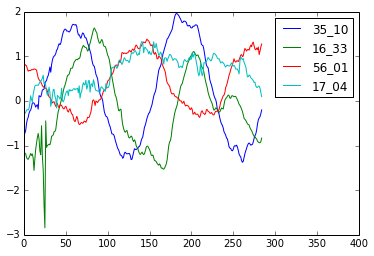

In [176]:
def plottingExamples(subject_tests, output=-1, desired_joints=[]):
    if(len(desired_joints) > 0):
        output = -1
    if(output > -1):
        for i in range(0,len(subject_tests)):
            # extract the event
            X = subject_tests[i][0]
            time_stamps = np.arange(X.shape[1])
            x_event = time_stamps
            y_event = X[output,:]
            mlabel = subject_tests[i][4]
            pb.plot(x_event, y_event, label=mlabel)
            pb.legend(loc='upper right')
            pb.xlim(0.0, 400)
    else:   
        for j in range(0, len(subject_tests)):
            X = subject_tests[j][0]
            time_stamps = np.arange(X.shape[1])
            x_event = time_stamps
            pb.figure(j)
            for i in desired_joints:      
                y_event = X[i,:]
                pb.xlabel('Time')
                pb.ylabel('Joint angle')
                title = 'Motion signals from: ' + subject_tests[j][4]
                pb.title(title)
                pb.plot(x_event, y_event)
                pb.xlim(0.0, 400)

#desired_joints = [8,9,10,12,15,16,17,19]
signal_totest = 13
plottingExamples(subject_tests, signal_totest)#, desired_joints)
'''for i in range(0,len(subject_tests)):
    # extract the event
    X = subject_tests[i][0]
    time_stamps = np.arange(X.shape[1])
    x_event = time_stamps
    y_event = X[26,:]
    mlabel = subject_tests[i][4]
    pb.plot(x_event, y_event, label=mlabel)
    pb.legend(loc='upper right')
    pb.xlim(0.0, 400)'''

In [177]:
def SetInputMOGP(X, input_t, n_signals, level_hier):
    sup_input = input_t[:,0]
    sup_input_id = np.zeros(input_t.shape[0])
    sup_output = X[0,:]
    tmp_output = sup_output
    tmp_input = sup_input
    
    for i in range(1,n_signals):
        tmp_input = np.append(tmp_input, sup_input)
        tmp_input_id = np.linspace(i,i,X.shape[1])
        sup_input_id = np.append(sup_input_id, tmp_input_id)
        tmp_output = np.append(tmp_output, X[i,:])

    sup_input = tmp_input
    #sup_input = sup_input*(1/100.0)
    sup_output = tmp_output
    sup_output = sup_output[:,None]
    all_X = np.vstack((sup_input, sup_input_id))
    all_X = np.transpose(all_X)
    return all_X, sup_output

def ComputeMSQERR(a,b):
    mean_sq_err = a - b
    mean_sq_err = np.power(mean_sq_err, 2)
    val_mean_sq_err = np.sum(mean_sq_err) / mean_sq_err.shape[0]
    return val_mean_sq_err

def ComputeSMSE(F, Y, var):
    mean_sq_err = Y - F
    mean_sq_err = np.power(mean_sq_err, 2)
    all_var = np.sum(var)
    sms_err = mean_sq_err/all_var
    val_smse = np.sum(sms_err)/F.shape[0]
    return val_smse

def ComputeSLL(F, Y, var, gaussian_noise_var):
    #print gaussian_noise_var.shape
    mean_sq_err = Y - F
    var = var + gaussian_noise_var
    mean_sq_err = np.power(mean_sq_err, 2)
    mean_sq_err = np.divide(mean_sq_err, 2.0*var)
    log_term = 0.5*np.log(var*2.0*np.pi)
    sll = log_term + mean_sq_err
    val_sll = np.sum(sll)/F.shape[0]
    return -1.0*val_sll

def PlottingModel(t,X,model,n_outputs):
    for i in range(n_outputs):
        model.plot(fignum=1,fixed_inputs=[(1, i)], plot_raw=True)

    for i in range(0,n_outputs):
        # extract the event 
        x_event = t
        y_event = X[i,:]
        pb.plot(x_event, y_event)

def OneOutputOneLayerHGP(subject_tests, out_id=0, optimized=True):
    Y = subject_tests[0][0][out_id,:]
    T = np.arange(Y.shape[0])
    T = T[:, None]
    time_size = T.shape[0]
    print time_size
    for i in range(1,len(subject_tests)):
        # extract the event
        YY = subject_tests[i][0][out_id,:]
        Y = np.vstack((Y, YY))
    print Y.shape, T.shape
    T_hat, Y_hat = SetInputMOGP(Y, T, Y.shape[0], 1)    
    print Y_hat.shape, T_hat.shape
    k1 = GPy.kern.RBF(1, variance=10., lengthscale=50.) + GPy.kern.Matern32(1, variance=2., lengthscale=40.)
    k2 = GPy.kern.RBF(1, variance=10., lengthscale=50.) + GPy.kern.Matern32(1, variance=2., lengthscale=40.)
    kernels = [k1,k2]
    HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels)    
    model = GPy.models.GPRegression(T_hat, Y_hat, HGP)
    if(optimized):
        model.optimize()  
    mu, var = model._raw_predict(T_hat)
    print 'Mean Squared Error', ComputeMSQERR(mu,Y_hat)
    print 'Standarized Mean Squared Error', ComputeSMSE(mu, Y_hat, var)
    print 'Standarized Log Loss', ComputeSLL(mu, Y_hat, var, model.Gaussian_noise.variance)
    C = HGP.K(T_hat, None)
    t = np.arange(X.shape[1])
    PlottingModel(t,Y,model,Y.shape[0])
    PlottingModel(t,Y,model,Y.shape[0])
    return model,C,Y_hat,T_hat
    

## regression with HGP hernel

### Regerssion without optimization

285
(3, 285) (285, 1)
(855, 1) (855, 2)
Mean Squared Error 0.0325913069684
Standarized Mean Squared Error 0.00127466262833
Standarized Log Loss -0.949475295292


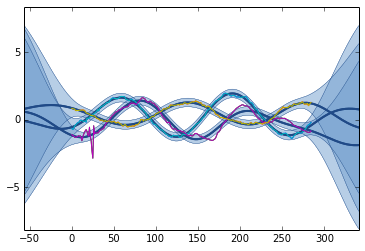

In [164]:
model, C, Y_hat, T_hat = OneOutputOneLayerHGP(subject_tests, signal_totest, False)


Name                 : GP regression
Log-likelihood       : -867.025367027
Number of Parameters : 5
Parameters:
  GP_regression.               |  Value  |  Constraint  |  Prior  |  Tied to
  hierarchy.rbf_1.variance     |   10.0  |     +ve      |         |         
  hierarchy.rbf_1.lengthscale  |   50.0  |     +ve      |         |         
  hierarchy.rbf_2.variance     |   10.0  |     +ve      |         |         
  hierarchy.rbf_2.lengthscale  |   50.0  |     +ve      |         |         
  Gaussian_noise.variance      |    1.0  |     +ve      |         |          (855, 855)


<function matplotlib.pyplot.colorbar>

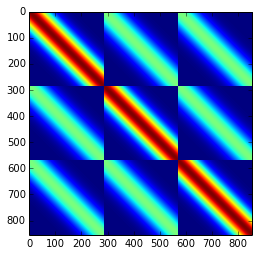

In [165]:
print model, C.shape
plt.imshow(C)
plt.colorbar

### Optimized regression

285
(4, 285) (285, 1)
(1140, 1) (1140, 2)
Mean Squared Error 0.00450819499675
Standarized Mean Squared Error 0.00312760867564
Standarized Log Loss 1.23859011161


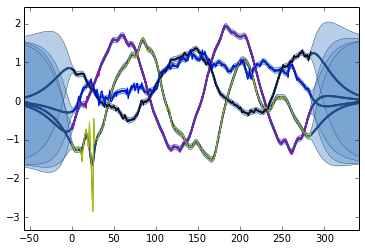

In [178]:
model, C, Y_hat, T_hat= OneOutputOneLayerHGP(subject_tests, signal_totest)

In [179]:
print model, C.shape


Name                 : GP regression
Log-likelihood       : 891.120168896
Number of Parameters : 9
Parameters:
  GP_regression.                     |        Value        |  Constraint  |  Prior  |  Tied to
  hierarchy.add_1.rbf.variance       |    0.0135332052274  |     +ve      |         |         
  hierarchy.add_1.rbf.lengthscale    |      56.2263086178  |     +ve      |         |         
  hierarchy.add_1.Mat32.variance     |  1.23195228302e-15  |     +ve      |         |         
  hierarchy.add_1.Mat32.lengthscale  |      72.2586486641  |     +ve      |         |         
  hierarchy.add_2.rbf.variance       |   5.9183101666e-14  |     +ve      |         |         
  hierarchy.add_2.rbf.lengthscale    |       61.245166615  |     +ve      |         |         
  hierarchy.add_2.Mat32.variance     |     0.620428364134  |     +ve      |         |         
  hierarchy.add_2.Mat32.lengthscale  |      24.9665214534  |     +ve      |         |         
  Gaussian_noise.variance        

<function matplotlib.pyplot.colorbar>

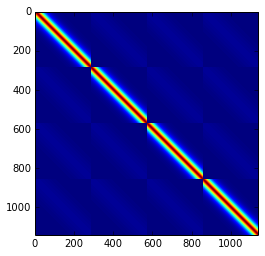

In [180]:
plt.imshow(C)
plt.colorbar

In [182]:
kernel_parent = model.kern.add_1
Y = subject_tests[0][0][0,:]
inp = np.arange(Y.shape[0])
T = inp[:, None]
print T.shape
C_parent = kernel_parent.K(T, None)

(285, 1)


### Parent Prior Covariance matrix

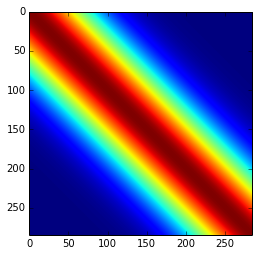

In [183]:
plt.imshow(C_parent)

## Computing the Parent Posterior

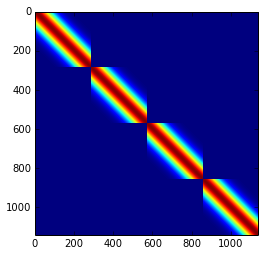

In [184]:
A_kron = np.eye(len(subject_tests)) 
C = np.matrix(C)
tmp_kg = np.kron(A_kron, C_parent)
posterior_mean = tmp_kg*np.linalg.inv(C)*Y_hat

posterior_cov = tmp_kg - (tmp_kg*np.linalg.inv(C)*tmp_kg.T)
plt.imshow(posterior_cov)
time_size = C_parent.shape[0] 

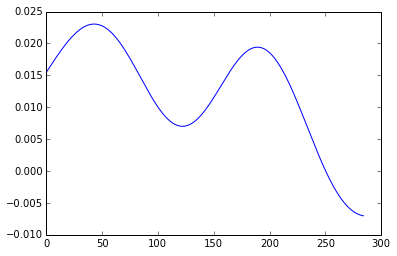

In [185]:
pb.plot(T_hat[0:time_size, 0], posterior_mean[0:time_size, 0])

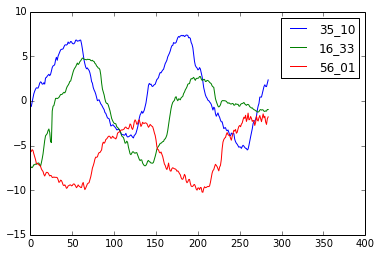

In [162]:
plottingExamples(subject_tests, signal_totest)